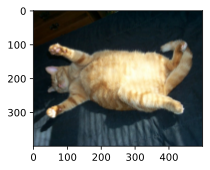

In [17]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

"""
    一种混类数据增强方法：Mixup
"""

d2l.set_figsize()
img = d2l.Image.open('../data/cat1.jpg')
d2l.plt.imshow(img)

In [18]:
# 给一张图片，一个增强方法，生成几行几列增强的数据，scale是画图用的
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

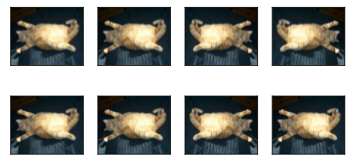

In [19]:
# 水平方向翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

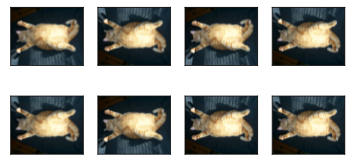

In [20]:
# 上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())


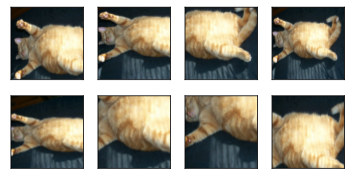

In [21]:
# 随机裁剪
# 第一个参数：生成的图片大小，scale：保存多大的原始图片，10%~100%
# ratio：高宽比（1比2或2比1）
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)


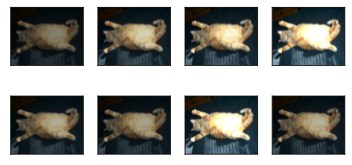

In [22]:
# 随机改亮度
# 亮度，对比度，饱和度，色调
# 此处亮度50%~150%
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))


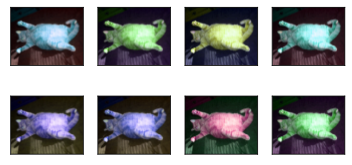

In [23]:
# 随机改亮度
# 亮度，对比度，饱和度，颜色
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5
))


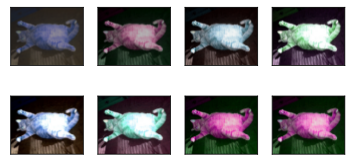

In [24]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

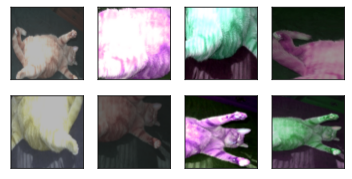

In [25]:
# 结合多种增广方法（这边是实际情况下用得最多的三种）
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug, shape_aug
])
apply(img, augs)

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

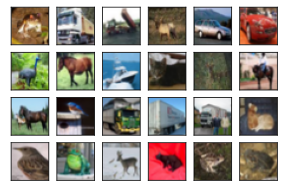

In [26]:
# 使用图像增广进行训练
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
all_images = torchvision.datasets.CIFAR10(
    train=True, root='../data', download=True
)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 6, scale=0.8)


In [27]:
# 只使用最简单的随机左右翻转
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor() # 把这些东西变成一个4D的矩阵
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [28]:
# 定义一个辅助函数，以便于读取图像和应用图像增广
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="../data", train=is_train,
        transform=augs, download=True
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=is_train, 
        num_workers=4
    )
    return dataloader

In [29]:
# 定义一个函数，使用多GPU对模型进行训练和评估
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with mutiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None)
                )
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')


In [32]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3) # 这边的这个参数表示类别数

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight) # 其实默认已经初始化了

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10)


loss 0.165, train acc 0.943, test acc 0.858
1332.9 examples/sec on [device(type='cuda', index=0)]


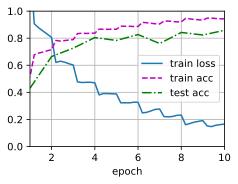

In [33]:
train_with_data_aug(train_augs, test_augs, net)

loss 0.068, train acc 0.977, test acc 0.809
1488.0 examples/sec on [device(type='cuda', index=0)]


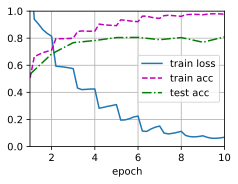

In [35]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10,
                                                                 3)  # 这边的这个参数表示类别数


def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)  # 其实默认已经初始化了


net.apply(init_weights)
train_with_data_aug(test_augs, test_augs, net) # 看一下不加强数据的结果
